# Rental Price Development

In [1]:
import pandas as pd

pd.set_option("display.max_columns", None)

import cufflinks as cf

cf.set_config_file(sharing="public", theme="pearl", offline=False)
cf.go_offline()

In [38]:
# read data
price_df = pd.read_csv("./data/forecasting.csv")
price_df.columns = price_df.columns.str.lower()
price_df["date"] = pd.to_datetime(price_df["date"])
len(price_df)

43544

## Feature Engineering

In [40]:
price_df[price_df["categories"].str.match("DUPLEX")]["categories"].unique()

array(['DUPLEX'], dtype=object)

In [3]:
# extract features

price_df["is_apartment"] = (
    price_df["categories"].map(lambda x: "APARTMENT" in x).map(int)
)
price_df["categories"] = price_df["categories"].str.replace("APARTMENT, ", "")

price_df["is_duplex"] = price_df["categories"].map(lambda x: "DUPLEX" in x).map(int)
price_df["categories"] = price_df["categories"].str.replace("DUPLEX, ", "")


price_df["is_house"] = price_df["categories"].map(lambda x: "HOUSE" in x).map(int)
price_df["categories"] = price_df["categories"].str.replace("HOUSE, ", "")

# categorize space sizes
d = {range(0, 50): "sm", range(50, 100): "md", range(100, 2000): "bg"}

price_df["size"] = price_df["space"].apply(
    lambda x: next((v for k, v in d.items() if x in k), "sm")
)

# categorize with ChatGPT
residential = [
    "DUPLEX",
    "FURNISHED_FLAT",
    "APARTMENT",
    "FLAT",
    "ROOF_FLAT",
    "ATTIC_FLAT",
    "LOFT",
    "SINGLE_ROOM",
    "STUDIO",
    "HOUSE",
    "ROW_HOUSE",
    "DUPLEX, MAISONETTE",
    "HOUSE, SINGLE_HOUSE",
    "ROW_HOUSE",
    "ATTIC",
    "BIFAMILIAR_HOUSE",
    "HOUSE, BIFAMILIAR_HOUSE",
    "TERRACE_FLAT",
    "BACHELOR_FLAT",
    "HOUSE, VILLA",
    "HOUSE, MULTIPLE_DWELLING",
    "VILLA",
]

commercial = [
    "OFFICE",
    "COMMERCIAL",
    "RETAIL, PRACTICE",
    "SHOP, ATELIER",
    "RETAIL, COMMERCIAL",
    "RESTAURANT",
    "WORKSHOP",
    "RETAIL, SHOP",
    "SHOP",
    "RESIDENTIAL_COMMERCIAL_BUILDING",
    "HOBBY_ROOM",
    "INDUSTRIAL_OBJECT",
    "STORAGE_ROOM",
    "ATELIER",
    "CAFE_BAR, RESTAURANT",
    "RETAIL, HAIRDRESSER",
    "RETAIL_SPACE, ATELIER",
    "ADVERTISING_AREA",
    "FACTORY",
    "RETAIL, STORAGE_ROOM",
    "UNDERGROUND_SLOT",
    "CAFE_BAR, BAR",
    "PRACTICE",
    "COFFEEHOUSE",
]

price_df["is_residential"] = price_df["categories"].isin(residential).map(int).fillna(0)
price_df["is_commercial"] = price_df["categories"].isin(commercial).map(int).fillna(0)

In [4]:
# remove NAs in target
print(price_df.price.isna().value_counts())
print(price_df.space.isna().value_counts())

price_df = price_df.dropna(subset=["price", "space"])

# remove outliers
price_df = price_df[price_df.eval("price/space") < 90]
len(price_df)

False    37397
True      6147
Name: price, dtype: int64
False    34545
True      8999
Name: space, dtype: int64


30761

In [5]:
price_df.drop(columns=["date", "categories"]).corr().style.background_gradient(
    cmap="coolwarm"
)

/var/folders/8y/630_g50j6sg5c2q1qypy80pw0000gn/T/ipykernel_73392/4014027835.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,price,space,is_apartment,is_duplex,is_house,is_residential,is_commercial
price,1.000000,0.818750,-0.260752,0.171670,0.253495,-0.209745,0.110703
space,0.818750,1.000000,-0.187960,0.247368,0.270653,-0.265228,0.155516
is_apartment,-0.260752,-0.187960,1.000000,-0.268149,-0.295760,0.300939,-0.274301
is_duplex,0.171670,0.247368,-0.268149,1.000000,-0.023956,-0.102629,-0.022218
is_house,0.253495,0.270653,-0.295760,-0.023956,1.000000,-0.357388,-0.010500
is_residential,-0.209745,-0.265228,0.300939,-0.102629,-0.357388,1.000000,-0.730216
is_commercial,0.110703,0.155516,-0.274301,-0.022218,-0.010500,-0.730216,1.000000


In [6]:
residential_df = price_df.query("is_residential == 1").drop(
    columns=["is_commercial", "is_residential"]
)
len(residential_df)

30078

In [7]:
residential_df.sort_values("is_apartment")

,date,price,space,categories,is_apartment,is_duplex,is_house,size
0,2018-04-07,2650.0,190.0,DUPLEX,0,1,0,bg
14975,2019-07-15,2300.0,106.0,LOFT,0,0,0,bg
14980,2019-04-12,2300.0,106.0,LOFT,0,0,0,bg
38938,2019-10-25,2500.0,176.0,ROOF_FLAT,0,0,0,bg
30384,2018-08-31,2850.0,70.0,FURNISHED_FLAT,0,0,0,md
...,...,...,...,...,...,...,...,...
15018,2019-04-30,3800.0,164.0,APARTMENT,1,0,0,bg
15017,2021-08-11,940.0,24.0,FLAT,1,0,0,sm
15016,2019-12-05,2250.0,82.0,APARTMENT,1,0,0,md
15031,2019-02-01,1485.0,84.0,APARTMENT,1,0,0,md


In [8]:
residential_df.join(pd.get_dummies(residential_df["categories"]).applymap(int)).drop(
    columns=["date", "categories"]
).corr().style.background_gradient(cmap="coolwarm")

/var/folders/8y/630_g50j6sg5c2q1qypy80pw0000gn/T/ipykernel_73392/4052620087.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



,price,space,is_apartment,is_duplex,is_house,APARTMENT,ATTIC,ATTIC_FLAT,BACHELOR_FLAT,BIFAMILIAR_HOUSE,DUPLEX,FLAT,FURNISHED_FLAT,LOFT,ROOF_FLAT,ROW_HOUSE,SINGLE_ROOM,STUDIO,TERRACE_FLAT,VILLA
price,1.000000,0.792546,-0.240276,0.196302,0.196900,-0.130956,-0.069157,0.101575,-0.001015,0.107344,0.196302,-0.148167,0.306969,0.032875,0.043559,0.161225,-0.139220,-0.072907,0.012549,0.100057
space,0.792546,1.000000,-0.130502,0.287969,0.202945,-0.048847,-0.080010,0.076990,-0.004337,0.131835,0.287969,-0.068746,0.010316,0.048733,0.078495,0.155572,-0.225249,-0.128584,0.012529,0.094671
is_apartment,-0.240276,-0.130502,1.000000,-0.317878,-0.233426,0.305530,-0.068065,-0.139695,-0.013242,-0.111149,-0.317878,0.295280,-0.373159,-0.087702,-0.240488,-0.203734,-0.181241,-0.123594,-0.030329,-0.051086
is_duplex,0.196302,0.287969,-0.317878,1.000000,-0.016931,-0.158088,-0.009357,-0.022290,-0.002234,-0.008062,1.000000,-0.152784,-0.060279,-0.014212,-0.037459,-0.014777,-0.025896,-0.018609,-0.005698,-0.003705
is_house,0.196900,0.202945,-0.233426,-0.016931,1.000000,-0.071319,-0.004221,-0.010056,-0.001008,0.476165,-0.016931,-0.068926,-0.027194,-0.006411,-0.016899,0.872800,-0.011682,-0.008395,-0.002571,0.038424
APARTMENT,-0.130956,-0.048847,0.305530,-0.158088,-0.071319,1.000000,-0.039413,-0.093893,-0.009411,-0.033959,-0.158088,-0.643570,-0.253912,-0.059863,-0.157786,-0.062247,-0.109080,-0.078387,-0.024003,-0.015608
ATTIC,-0.069157,-0.080010,-0.068065,-0.009357,-0.004221,-0.039413,1.000000,-0.005557,-0.000557,-0.002010,-0.009357,-0.038091,-0.015028,-0.003543,-0.009339,-0.003684,-0.006456,-0.004639,-0.001421,-0.000924
ATTIC_FLAT,0.101575,0.076990,-0.139695,-0.022290,-0.010056,-0.093893,-0.005557,1.000000,-0.001327,-0.004788,-0.022290,-0.090744,-0.035802,-0.008441,-0.022248,-0.008777,-0.015380,-0.011053,-0.003384,-0.002201
BACHELOR_FLAT,-0.001015,-0.004337,-0.013242,-0.002234,-0.001008,-0.009411,-0.000557,-0.001327,1.000000,-0.000480,-0.002234,-0.009095,-0.003588,-0.000846,-0.002230,-0.000880,-0.001542,-0.001108,-0.000339,-0.000221
BIFAMILIAR_HOUSE,0.107344,0.131835,-0.111149,-0.008062,0.476165,-0.033959,-0.002010,-0.004788,-0.000480,1.000000,-0.008062,-0.032820,-0.012949,-0.003053,-0.008047,-0.003174,-0.005563,-0.003998,-0.001224,-0.000796


In [9]:
residential_df

,date,price,space,categories,is_apartment,is_duplex,is_house,size
0,2018-04-07,2650.0,190.0,DUPLEX,0,1,0,bg
1,2018-03-15,2850.0,190.0,DUPLEX,0,1,0,bg
2,2020-06-05,4600.0,170.0,FURNISHED_FLAT,1,0,0,bg
10,2019-12-19,1270.0,65.0,APARTMENT,1,0,0,md
13,2018-06-25,1200.0,62.0,APARTMENT,1,0,0,md
...,...,...,...,...,...,...,...,...
43536,2020-08-12,2190.0,97.0,FLAT,1,0,0,md
43537,2021-02-04,1320.0,75.0,FLAT,1,0,0,md
43538,2020-08-10,1950.0,120.0,LOFT,1,0,0,bg
43539,2020-08-14,1990.0,70.0,DUPLEX,1,1,0,md


In [10]:
residential_df.eval("price/space").iplot(kind="hist", title="Distribution of price/sqm")

## Modelling

### Regression

In [49]:
from pycaret.regression import RegressionExperiment

s = RegressionExperiment()
s.setup(
    residential_df.drop(columns=["date"]),  # "categories"
    target="price",
    session_id=123,
    log_experiment=True,
    experiment_name="price_forecast",
)

,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Original data shape,"(30078, 7)"
4,Transformed data shape,"(30078, 23)"
5,Transformed train set shape,"(21054, 23)"
6,Transformed test set shape,"(9024, 23)"
7,Numeric features,4
8,Categorical features,2
9,Preprocess,True


> run `mlflow ui` in the terminal to check history of runs

In [50]:
best = s.compare_models(
    include=[
        "lr",
        "ridge",
        "lasso",
        "huber",
        "rf",
        "catboost",
        "lightgbm",
        "knn",
        "xgboost",
    ]
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,249.0435,170731.7668,412.5367,0.7686,0.2158,0.1635,0.4550
lightgbm,Light Gradient Boosting Machine,250.2853,171732.9471,413.8384,0.7673,0.2174,0.1649,0.4160
xgboost,Extreme Gradient Boosting,246.9666,172516.0984,414.7052,0.7660,0.2154,0.1621,0.2190
rf,Random Forest Regressor,246.4582,173050.7743,415.4578,0.7652,0.2159,0.1617,0.1960
lr,Linear Regression,272.0786,202054.2481,448.7931,0.7270,0.2364,0.1793,0.0230
ridge,Ridge Regression,272.1367,202084.2854,448.8252,0.7270,0.2364,0.1793,0.0230
lasso,Lasso Regression,274.0244,203096.3400,449.9177,0.7256,0.2383,0.1816,0.0280
knn,K Neighbors Regressor,272.1964,203793.3984,450.7860,0.7234,0.2312,0.1772,0.0490
huber,Huber Regressor,269.2049,206709.5279,453.7766,0.7211,0.2345,0.1750,0.0750


In [51]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [52]:
s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,248.3400,160039.5050,400.0494,0.7819,0.2255,0.2206


,space,categories,is_apartment,is_duplex,is_house,size,price,prediction_label
29486,123.0,APARTMENT,1,0,0,bg,2650.0,2579.073608
4444,70.0,APARTMENT,1,0,0,md,1250.0,1415.519546
42627,110.0,APARTMENT,1,0,0,bg,3000.0,2285.520461
20557,70.0,FLAT,1,0,0,md,1340.0,1453.198371
8643,89.0,FLAT,1,0,0,md,2595.0,1782.076876
...,...,...,...,...,...,...,...,...
12884,55.0,FLAT,1,0,0,md,1200.0,1187.660429
1311,48.0,APARTMENT,1,0,0,sm,1600.0,1055.900869
15879,60.0,FLAT,1,0,0,md,1230.0,1232.240930
29457,123.0,APARTMENT,1,0,0,bg,2600.0,2579.073608


In [53]:
tuned_model = s.tune_model(best, optimize="R2", search_library="scikit-optimize")
s.evaluate_model(tuned_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,273.5568,197739.6337,444.6792,0.7464,0.2410,0.1830
1,260.2246,166177.5843,407.6488,0.7334,0.2258,0.1737
2,279.7497,229358.1693,478.9135,0.6830,0.2384,0.1818
3,262.4361,181613.4169,426.1613,0.7401,0.2294,0.1772
4,274.7735,214201.0509,462.8186,0.7339,0.2542,0.1984
5,270.7105,198349.7102,445.3647,0.7451,0.2320,0.1784
6,272.1716,228302.7772,477.8104,0.7362,0.2170,0.1648
7,269.7492,174836.6765,418.1348,0.7540,0.2279,0.1759
8,266.8926,175765.3854,419.2438,0.7415,0.2310,0.1783


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

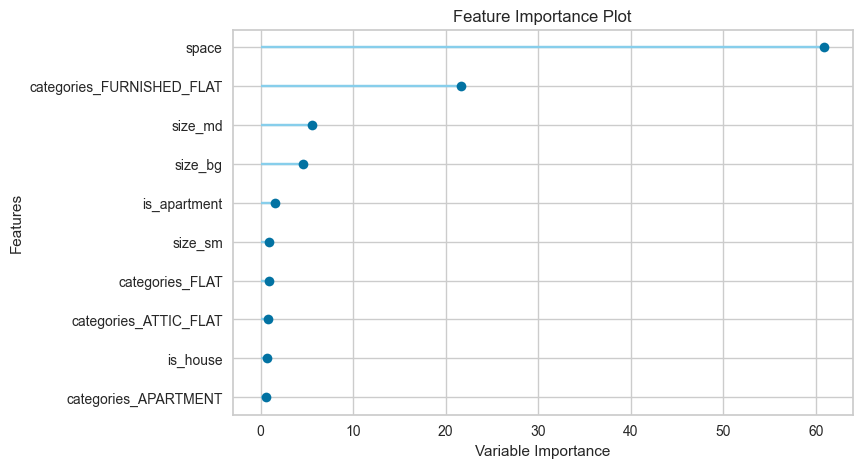

In [54]:
s.plot_model(tuned_model, plot="feature")

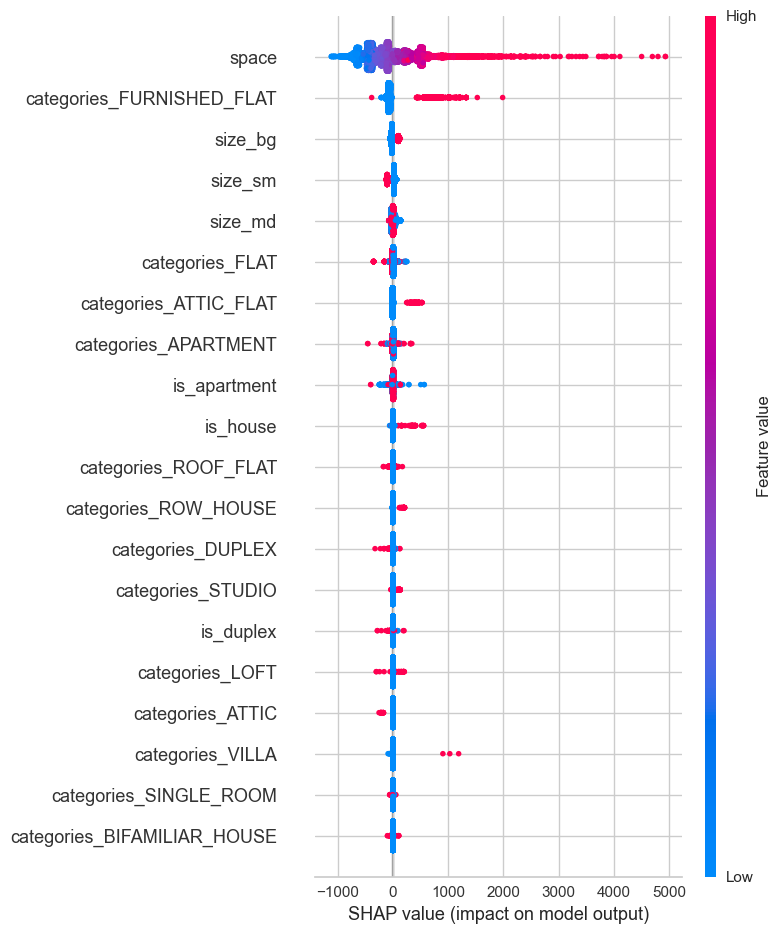

In [55]:
s.interpret_model(tuned_model, plot="summary")

In [56]:
final = s.finalize_model(tuned_model)
s.save_model(tuned_model, model_name="housing-price-regression")

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['space', 'is_apartment',
                                              'is_duplex', 'is_house'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['categories', 'size'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['categories', 'size'],
                                     transformer=OneHotEncoder(cols=['categories',
                                                                     'size'],
                                                               handle_missing='return_nan',
                                                               use_cat_names=True))),
                 ('trained_model',
                  <catboost.

### Model Price per square meter

#### Regression

In [57]:
ts_df = residential_df.dropna(subset=["space"]).reset_index(drop=True)
ts_df["price_sqm"] = ts_df.eval("price/space").map(lambda x: int(x * 100) / 100)
ts_df = ts_df.join(pd.get_dummies(ts_df["categories"]).applymap(int))
ts_df.shape

(30078, 24)

In [58]:
ts_df.set_index("date")["price_sqm"].resample("W").mean().iplot()

In [59]:
from pycaret.regression import RegressionExperiment

s = RegressionExperiment()
s.setup(
    ts_df.drop(columns=["date", "space", "price", "size"]),  # drop space and date
    target="price_sqm",
    session_id=123,
    log_experiment=True,
    experiment_name="price_sqm_forecast",
)

,Description,Value
0,Session id,123
1,Target,price_sqm
2,Target type,Regression
3,Original data shape,"(30078, 20)"
4,Transformed data shape,"(30078, 34)"
5,Transformed train set shape,"(21054, 34)"
6,Transformed test set shape,"(9024, 34)"
7,Numeric features,18
8,Categorical features,1
9,Preprocess,True


In [60]:
best = s.compare_models(
    include=[
        "lr",
        "ridge",
        "lasso",
        "huber",
        "rf",
        "catboost",
        "lightgbm",
        "knn",
        "xgboost",
    ]
)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,4.0231,38.3805,6.1889,0.3909,0.2362,0.1904,0.3820
lightgbm,Light Gradient Boosting Machine,4.0231,38.3784,6.1888,0.3909,0.2362,0.1904,0.2850
xgboost,Extreme Gradient Boosting,4.0230,38.3805,6.1889,0.3909,0.2362,0.1904,0.0350
rf,Random Forest Regressor,4.0228,38.3814,6.1890,0.3908,0.2362,0.1904,0.1700
lr,Linear Regression,4.0250,38.4250,6.1923,0.3903,0.2362,0.1905,0.0210
ridge,Ridge Regression,4.0215,38.4172,6.1918,0.3903,0.2363,0.1904,0.0170
huber,Huber Regressor,3.9620,38.7258,6.2164,0.3855,0.2354,0.1837,0.0930
knn,K Neighbors Regressor,4.4023,41.5797,6.4427,0.3396,0.2488,0.2113,0.0460
lasso,Lasso Regression,5.2116,63.1864,7.9381,-0.0008,0.2853,0.2337,0.0200


In [61]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### Time Series

In [62]:
from pycaret.time_series import TSForecastingExperiment

s = TSForecastingExperiment()

In [63]:
# Resample at weekly period
ts_data = ts_df.query("is_apartment == 1").set_index("date").resample("W").mean()

In [64]:
s.setup(ts_data, fh=12, fold=10, session_id=123, target="price_sqm")

,Description,Value
0,session_id,123
1,Target,price_sqm
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(209, 21)"
5,Transformed data shape,"(209, 21)"
6,Transformed train set shape,"(197, 21)"
7,Transformed test set shape,"(12, 21)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [65]:
best = s.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
auto_arima,Auto ARIMA,0.6354,0.5831,0.5526,0.6822,0.0243,0.0247,-0.3632,0.0740
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.6727,0.6147,0.5834,0.7171,0.0255,0.0254,-0.2669,0.0510
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.6896,0.6190,0.5986,0.7213,0.0263,0.0261,-0.2069,0.0510
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.7297,0.6346,0.6336,0.7391,0.0278,0.0274,-0.3628,0.0550
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,0.7600,0.6580,0.6654,0.7712,0.0292,0.0289,-0.5781,0.0480
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.7929,0.6658,0.6957,0.7814,0.0306,0.0300,-1.0181,0.0460
croston,Croston,0.8886,0.8490,0.7578,0.9784,0.0328,0.0333,-0.5542,0.0050
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.9263,0.8223,0.7979,0.9516,0.0349,0.0354,-1.5531,0.0530
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.9330,0.8470,0.8079,0.9852,0.0356,0.0352,-1.3783,0.0610
ada_cds_dt,AdaBoost w/ Cond. Deseasonalize & Detrending,0.9429,0.8511,0.8114,0.9859,0.0356,0.0354,-0.8036,0.0640


In [84]:
s.plot_model(best, plot="forecast")

In [98]:
figure = s.plot_model(best, plot="forecast", return_fig=True)
figure.write_html("dashboard/ts-price-forecast.html", full_html=False)

In [75]:
s.predict_model(best, fh=12)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Auto ARIMA,0.3541,0.3279,0.3201,0.3935,0.0144,0.0143,0.6659


,y_pred
2021-10-11/2021-10-17,22.2993
2021-10-18/2021-10-24,23.1253
2021-10-25/2021-10-31,22.4085
2021-11-01/2021-11-07,22.0524
2021-11-08/2021-11-14,21.4150
2021-11-15/2021-11-21,22.5942
2021-11-22/2021-11-28,21.9586
2021-11-29/2021-12-05,22.0287
2021-12-06/2021-12-12,22.5623
2021-12-13/2021-12-19,22.3091


In [88]:
s.plot_model(best, plot="insample")

In [69]:
s.plot_model(plot="diagnostics")

In [89]:
final_best = s.finalize_model(best)

In [91]:
s.save_model(final_best, model_name="ts-price-forecast")

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 AutoARIMA(random_state=123,
                                                                                                                                           sp=9,
                                                                                                                                           suppress_warnings=True))]))]))]))]),
 'ts-price-forecast.pkl')

#### Out of the box AutoArima

In [154]:
import pmdarima as pm

model = pm.auto_arima(
    ts_data.price_sqm,
    m=12,
    seasonal=True,
    max_order=20,
    test="adf",
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    trace=False,
)
model.fit(ts_data.price_sqm)
forecast = model.predict(n_periods=30, return_conf_int=True)
forecast_df = pd.DataFrame(forecast[0], columns=["price_sqm"])

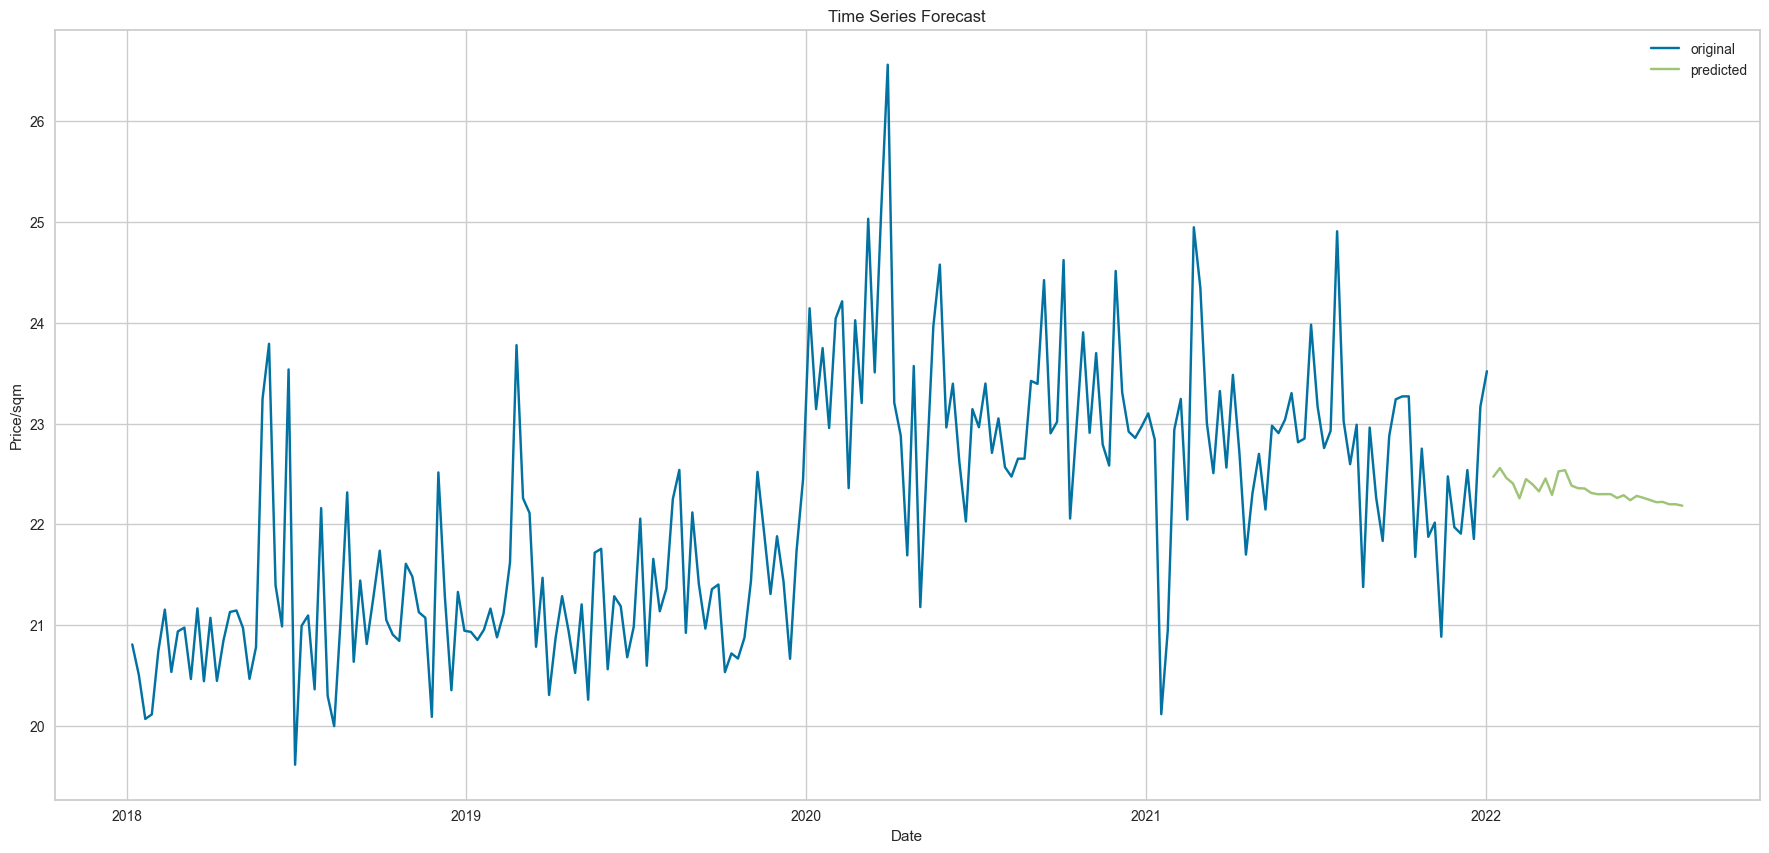

In [156]:
import matplotlib.pyplot as plt  # visualization library

plt.figure(figsize=(22, 10))
plt.plot(ts_data.price_sqm, label="original")
plt.plot(forecast_df["price_sqm"], label="predicted")
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Price/sqm")
plt.legend()
plt.show()